<a href="https://colab.research.google.com/github/JhonathanOrtiz/DeepCV-Pytorch/blob/master/CNN_classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> # What really is an image.

In Deep Learnig when we work with images we use Convolutional Neural Networks, Since that Architecture are specialist in this task. Why? First We need to know How a computer read an image.



![texto alternativo](http://iesalmadraba.org/dibujo/files/2018/01/9781588906380_c002_f001-300x232.jpg)


For a PC an image is matrix where each value is a pixel intensity, for example whether the value is 0 the pixel white so, while de value increase the color it's color darkness until black (255). We can deploy those images with the appropiate pixel value-distributions.

![Texto alternativo](https://www.blogdelfotografo.com/wp-content/uploads/2017/10/DSC8362.jpg)



### Now, what happen when the image has many colors?

We can't use just a matrix if the image has many color because as you can see we conly respresent a gray-scale. *SOLUTION* We can use the three light color, RED GREEN AND BLUE from here RGB image format, now if we can three color we can build three matrix (One by color) when the same idea about pixel intensity, but for each color, so we stack the matrix and voilà, COLOR IMAGE.


![Texto](https://www.researchgate.net/profile/Jane_Courtney2/publication/267210444/figure/fig6/AS:295732335661069@1447519491773/A-three-dimensional-RGB-matrix-Each-layer-of-the-matrix-is-a-two-dimensional-matrix.png)



With that approach an computer can see the wolrd, and with this intuition we can start to understand how to a computer can classify images, or detect your face on your smartfphone camera.




> Convolutional Neural Network

Nowdays an image can have until 1000px x 800px for a feedforward neural network that is 8e5 input feature and if we have a RGB image 24e5 input features. It's too much. Convolutional neural network. How it works?

![Texto alternativo](https://www.diegocalvo.es/wp-content/uploads/2017/07/convoluci%C3%B3n.png)

Given a gray-scale image like the image above, we build a filter (small matrix) and we slice over image, those filter can extract important features for the images, this out weights, the parameters that our network should learn. 

If you can know more about neural net. [Click here](https://arxiv.org/abs/1512.07108)





In [19]:
#import the modules
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torch import nn

#Download the train dataset from torch
train_ds = CIFAR10('data', transform=Compose([Resize((32,32)), 
                                                        ToTensor(), 
                                                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                                                        download=True)

val_ds = CIFAR10('data', transform=Compose([Resize((32,32)), 
                                                        ToTensor(), 
                                                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                                                        download=True, train=False)

test_len = int(len(val_ds)*0.1)
val_len = int(len(val_ds) - test_len)
val_ds, test_ds =  random_split(val_ds, [val_len, test_len])

print('Train dataset: {}, Validation dataset: {}, test dataset. {}' .format(len(train_ds), len(val_ds), len(test_ds)))

Files already downloaded and verified
Files already downloaded and verified
Train dataset: 50000, Validation dataset: 9000, test dataset. 1000




># DATA

To work inn Artificial Intelligence mean work with data, the model performace depends of your data. *Bad data bad model* we instace three dataset type why? With the train data we teach to our model, for example what is a dog, what's an apple.. with de validation data with you evaluate the how good your model works, and the test set your model is tested. Why another set for test our model? Because your finetuning your model and likely you're overfit your model with your valdation dataset. to know more about it [click here](https://www.fast.ai/2017/11/13/validation-sets/)

In [0]:
BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [0]:
#Compute the model accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
#Helpul for training display metrics
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))



> MODEL

Here we define the model that will make prediction on our data

See this guide [An efficient way to build your CNN](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7)

In the follow cell we define de newtork topology the numbers are the output features. **M** Represent An maxPooling layer.

The core idea, In Pytorch to define a convolutional layers we need the input feature and output feature, Now in the first layers we know that the image has three featrure maps (RGB) and we set the output size in 64, our image now has 64 matrix, MaxPoling layers make a downsampling factor 2.

![Text](https://www.researchgate.net/profile/Fernando_De_la_Rosa/publication/308783857/figure/fig7/AS:668316066660362@1536350375330/Red-neuronal-convolucional-4.jpg)

With CNN with extract the features so, we will need feed a feedforward neural network to clasify our image.

In [0]:
topology = [64, 'M', 128, 'M', 256, 256, 'M', 512, 'M', 512, 'M']

In [0]:
import torch.nn.functional as F 

class Net(ImageClassificationBase):

  def __init__(self,input_channel, output_size):
    super(Net, self).__init__()
    self.input_channel =  input_channel
    self.output_size = output_size
    self.convlayer = self.create_conv_layer(topology)
    self.fc = nn.Sequential(
        nn.Linear(512*1*1, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, output_size)
    )
  
  #Define the convolutional model
  def create_conv_layer(self, architecture):
    layers = []
    input_channel = self.input_channel

    for x in architecture: #For each value in our topology

      if type(x) == int: #If is a numbre build convolutional layer
        output_channel = x
        layers += [nn.Conv2d(input_channel, x, (3,3), 1, 1),
                   nn.BatchNorm2d(x),
                   nn.LeakyReLU()]
        
        input_channel = x 

      elif x == 'M': #Build Maxpooling layers
        layers += [nn.MaxPool2d((2,2), (2,2))]     

    return nn.Sequential(*layers)
    
#Forward pass
  def forward(self, x):
    x = self.convlayer(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x



> # Vanishing Gradient

While the image feed throughout the convolutional neural network, it's compressed so, if there are important imformation on earlier layers we lost this information therefore when we compute the gradient in earlier layers will be small to know more [click kere](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484)

Residual block avoid vanishing, for each layer we add the output and the input.


![Text](https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png)

In [0]:
import torch

#Create ResidualBlock
class block(ImageClassificationBase):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
      
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)
        
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [0]:
class ResNet(ImageClassificationBase):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [26]:
import torch
Model = Net(3, 10)
x = torch.rand(1,3,32,32)
Model.forward(x)

tensor([[-0.0651,  0.0698, -0.0613, -0.0530, -0.0282, -0.0171,  0.1181, -0.0428,
         -0.0337,  0.0472]], grad_fn=<AddmmBackward>)

In [0]:
#Get the divice that do you use GPU or CPU 
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [0]:
#Move the dataset to the GPU
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cuda')

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)



> # Training a model

Per epoch:

* Forward Pass: Make prediction over the train data.
* Compute Loss: Loss tell us how wrong is our model predictions, the idea is minimize it.

* Compute gradients: Is a derivatives set, and these derivative how fast change de loss function with respect to the trainable parameters Kernel, and Bias)

* Optimize: Update the parameters. *W - lr(gadients)*

    ![text](https://se.mathworks.com/help/deeplearning/gs/gettingstarted_nnblk.gif)

In [0]:
#Evaluate the model
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#Train model
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
def ResNet50(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=10):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())


test()

torch.Size([4, 1000])


In [33]:
model = to_device(Net(3,10), device)
hist = evaluate(model, val_loader)
hist

{'val_acc': 0.09757992625236511, 'val_loss': 2.302562713623047}

In [34]:
resnet = to_device(ResNet50(3, 10), device)
history = evaluate(resnet, val_loader)
history

{'val_acc': 0.09558170288801193, 'val_loss': 2.671478748321533}

In [35]:
history_= fit(15, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5252, val_acc: 0.4159
Epoch [1], val_loss: 1.2286, val_acc: 0.5644
Epoch [2], val_loss: 1.0342, val_acc: 0.6398
Epoch [3], val_loss: 0.9514, val_acc: 0.6722
Epoch [4], val_loss: 0.8623, val_acc: 0.7185
Epoch [5], val_loss: 0.8660, val_acc: 0.7222
Epoch [6], val_loss: 0.7951, val_acc: 0.7526
Epoch [7], val_loss: 0.7914, val_acc: 0.7682
Epoch [8], val_loss: 0.7336, val_acc: 0.7763
Epoch [9], val_loss: 0.7895, val_acc: 0.7644
Epoch [10], val_loss: 0.7464, val_acc: 0.7910
Epoch [11], val_loss: 0.8293, val_acc: 0.7825
Epoch [12], val_loss: 0.8402, val_acc: 0.7773
Epoch [13], val_loss: 0.8362, val_acc: 0.7952
Epoch [14], val_loss: 0.8216, val_acc: 0.7985


In [36]:
history = fit(15, 1e-3, resnet, train_loader, val_loader)

Epoch [0], val_loss: 1.9575, val_acc: 0.3383
Epoch [1], val_loss: 2.0884, val_acc: 0.2620
Epoch [2], val_loss: 1.6057, val_acc: 0.4049
Epoch [3], val_loss: 1.3885, val_acc: 0.4999
Epoch [4], val_loss: 1.3229, val_acc: 0.5312
Epoch [5], val_loss: 1.1360, val_acc: 0.5980
Epoch [6], val_loss: 1.0482, val_acc: 0.6288
Epoch [7], val_loss: 0.9867, val_acc: 0.6574
Epoch [8], val_loss: 0.9318, val_acc: 0.6785
Epoch [9], val_loss: 0.8926, val_acc: 0.6877
Epoch [10], val_loss: 0.8674, val_acc: 0.7010
Epoch [11], val_loss: 0.8643, val_acc: 0.7043
Epoch [12], val_loss: 0.8524, val_acc: 0.7128
Epoch [13], val_loss: 0.8142, val_acc: 0.7285
Epoch [14], val_loss: 0.8349, val_acc: 0.7341


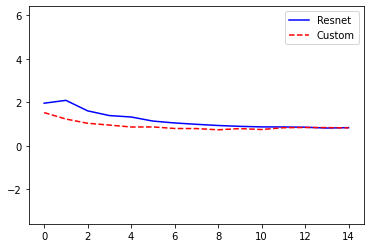

In [37]:
#Plots losses
losses_res = [x['val_loss']for x in history]
losses_cus = [x['val_loss']for x in history_]

fig, ax = plt.subplots()
ax.plot(losses_res, '-b', label='Resnet')
ax.plot(losses_cus, '--r', label='Custom')
ax.axis('equal')
leg = ax.legend()
plt.show()

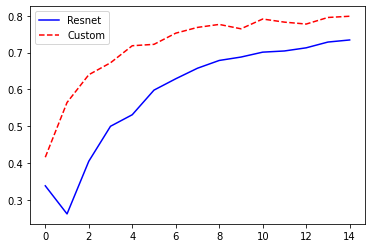

In [38]:
#Plot metrics
acc_res = [x['val_acc'] for x in history]
acc_custom = [x['val_acc'] for x in history_]

fig, ax = plt.subplots()
ax.plot(acc_res, '-b', label='Resnet')
ax.plot(acc_custom, '--r', label='Custom')
plt.legend()

In [39]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import numpy as np

losses = []
for batch in test_loader:
  images, label = batch
  output = model.forward(images)
  loss = F.cross_entropy(output, label)
  losses.append(loss)

  
x = images.cpu().data.numpy()
y_pre = output.cpu().data.numpy()
y_true = label.cpu().data.numpy()

list(y_pre)
print(label)
ypre = []

for i in y_pre:
  ypre.append(np.argmax(i))

ypre = np.array(ypre)

print(ypre.shape, y_true.shape, images.shape)

conf_m = np.array(confusion_matrix(y_true, ypre))
conf_m.shape

tensor([8, 4, 9, 6, 7, 4, 2, 7], device='cuda:0')
(8,) (8,) torch.Size([8, 3, 32, 32])


(9, 9)

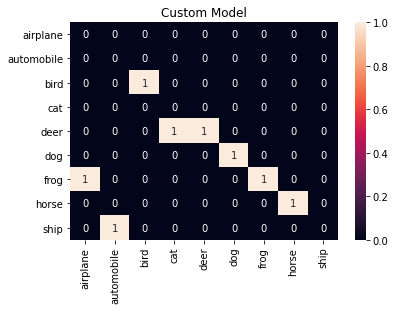

In [42]:
import pandas as pd
import seaborn as sns

classes = [i for i in train_ds.classes]
target = [i for i in train_ds.classes]
df =  pd.DataFrame(conf_m, classes[:-1], target[:-1])
plt.title('Custom Model')
sns.heatmap(df, annot=True)

In [43]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import numpy as np
for batch in test_loader:
  images, label = batch
  output = resnet.forward(images)
  break

x = images.cpu().data.numpy()
y_pre = output.cpu().data.numpy()
y_true = label.cpu().data.numpy()

list(y_pre)
print(label)
ypre = []

for i in y_pre:
  ypre.append(np.argmax(i))

ypre = np.array(ypre)

print(ypre.shape, y_true.shape, images.shape)

conf_m = np.array(confusion_matrix(y_true, ypre))
conf_m.shape

tensor([2, 9, 9, 3, 8, 9, 0, 0, 9, 1, 4, 5, 8, 3, 1, 6], device='cuda:0')
(16,) (16,) torch.Size([16, 3, 32, 32])


(10, 10)

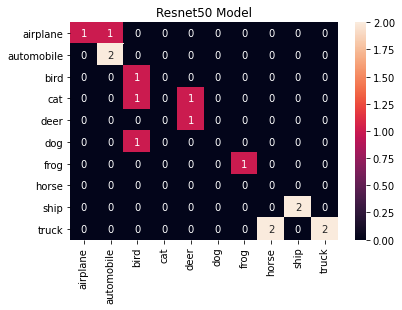

In [44]:
import pandas
import seaborn as sns

classes = [i for i in train_ds.classes]
target = [i for i in train_ds.classes]
df =  pd.DataFrame(conf_m, classes[:], target[:])
plt.title('Resnet50 Model')
sns.heatmap(df, annot=True)